In [1]:
import spacy

import torch
import torchtext
import torchtext.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
import random
from torchtext.vocab import Vocab
import matplotlib.pyplot as plt
import numpy as np


from dataclasses import dataclass, field


from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

In [3]:
nlp = spacy.load('en')


In [4]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [5]:
import os
import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np

import torchtext

SEED = 1234


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = torchtext.datasets.IMDB.splits(text_field=TEXT,
                                      label_field=LABEL,
                                      train='train',
                                      test='test',
                                      path='data/aclImdb')
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

len(train_data), len(valid_data), len(test_data)

(17500, 7500, 25000)

In [6]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim),
                                              #padding_mode='circular',
                                              padding=(6,0))
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        #text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

INPUT_DIM = 25002
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = 1

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

model.load_state_dict(torch.load('<MODEL-PATH>'))
model.to(device)
model.eval()


CNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1), padding=(6, 0))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1), padding=(6, 0))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1), padding=(6, 0))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [7]:

MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)


In [8]:
print('Vocabulary Size: ', len(TEXT.vocab))

Vocabulary Size:  25002


In [9]:
lig = LayerIntegratedGradients(model, model.embedding)

In [10]:
PAD_IND = TEXT.vocab.stoi['<pad>']
PAD_IND

1

In [11]:
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

In [12]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 15, label = 0):
    #text = [tok.text for tok in nlp.tokenizer(sentence)]
    #if len(text) < min_len:
    #    text += ['<pad>'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = torch.sigmoid(model(input_indices)).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=500, return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [13]:
nlp = spacy.load('en')

min_len = 15
sentence = 'The film is great'
text = [tok.text for tok in nlp.tokenizer(sentence)]
if len(text) < min_len:
    # right padding
    text += ['the'] * (min_len - len(text))
    # left padding
    #text = ['<pad>'] * (min_len - len(text)) + text
    #circular padding
    #text = text + text[:(min_len - len(text))]
    indexed = [TEXT.vocab.stoi[t] for t in text]

input_indices = torch.tensor(indexed, device=device)
input_indices = input_indices.unsqueeze(0)


In [14]:
interpret_sentence(model, sentence, label=1)


pred:  pos ( 0.92 ) , delta:  tensor([0.0004])


In [15]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)


Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.92),pos,0.83,The film is great the the the the the the the the the the the


In [18]:
saved_conv_activations = {}

def fwd_hook_wrapper(name):
    def conv_fwd_hook(module, input, output):
        if name in ['dropout', 'fc']:
            saved_conv_activations[name] = input[0]
        else:
            saved_conv_activations[name] = F.relu(output)
    return conv_fwd_hook

hook1 = model.convs[0].register_forward_hook(fwd_hook_wrapper(str(model.convs[0].kernel_size)))
hook2 = model.convs[1].register_forward_hook(fwd_hook_wrapper(str(model.convs[1].kernel_size)))
hook3 = model.convs[2].register_forward_hook(fwd_hook_wrapper(str(model.convs[2].kernel_size)))

hook4 = model.dropout.register_forward_hook(fwd_hook_wrapper('dropout'))

hook5 = model.fc.register_forward_hook(fwd_hook_wrapper('fc'))

model(input_indices)

tensor([[2.4727]], grad_fn=<AddmmBackward>)

In [19]:
hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()

Visualizing feature maps

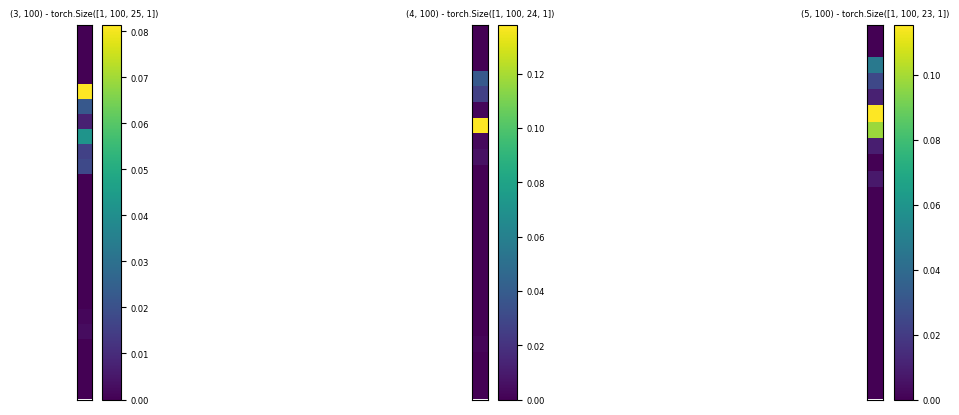

In [20]:

fig = plt.figure(figsize=(10, 5), dpi=100)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.9, hspace=0.4)
ind = 0
#avg_feat_maps = np.mean(outp['out'].detach().numpy(), axis=0)
for key in saved_conv_activations.keys():
    if key in ['dropout', 'fc']:
        continue
        act = saved_conv_activations[key].squeeze(-1).detach().numpy()
    else:
        act = torch.mean(saved_conv_activations[key].squeeze(0), axis=0).detach().numpy()

    ax = fig.add_subplot(1, 3, ind + 1)
    ax.set_title("{} - {}".format(key, saved_conv_activations[key].shape), fontsize=6)
    plt.imshow(act)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=6) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ind += 1
